## 中阶API

### 数据管道Dataset

如果需要训练的数据大小不大，例如不到1G，那么可以直接全部读入内存中进行训练，这样一般效率最高。

但如果需要训练的数据很大，例如超过10G，无法一次载入内存，那么通常需要在训练的过程中分批逐渐读入。

使用 `tf.data` API 可以构建数据输入管道，轻松处理大量的数据，不同的数据格式，以及不同的数据转换。

#### 构建数据管道


可以从 Numpy array, Pandas DataFrame, Python generator, csv文件, 文本文件, 文件路径, tfrecords文件等方式构建数据管道。

其中通过Numpy array, Pandas DataFrame, 文件路径构建数据管道是最常用的方法。

通过 `tfrecords` 文件方式构建数据管道较为复杂，需要对样本构建 `tf.Example` 后压缩成字符串写到 `tfrecords` 文件，读取后再解析成 `tf.Example`。

但`tfrecords`文件的优点是压缩后文件较小，便于网络传播，加载速度较快。


In [11]:
# 从Numpy array构建数据管道

import tensorflow as tf
import numpy as np 
from sklearn import datasets 
iris = datasets.load_iris()


ds1 = tf.data.Dataset.from_tensor_slices((iris["data"],iris["target"]))
for features,label in ds1.take(5):
    print(features,label)

tf.Tensor([5.1 3.5 1.4 0.2], shape=(4,), dtype=float64) tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor([4.9 3.  1.4 0.2], shape=(4,), dtype=float64) tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor([4.7 3.2 1.3 0.2], shape=(4,), dtype=float64) tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor([4.6 3.1 1.5 0.2], shape=(4,), dtype=float64) tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor([5.  3.6 1.4 0.2], shape=(4,), dtype=float64) tf.Tensor(0, shape=(), dtype=int64)


In [2]:
# 从 Pandas DataFrame构建数据管道
import tensorflow as tf
from sklearn import datasets 
import pandas as pd
iris = datasets.load_iris()
dfiris = pd.DataFrame(iris["data"],columns = iris.feature_names)
ds2 = tf.data.Dataset.from_tensor_slices((dfiris.to_dict("list"),iris["target"]))

for features,label in ds2.take(3):
    print(features,label)

{'sepal length (cm)': <tf.Tensor: shape=(), dtype=float32, numpy=5.1>, 'sepal width (cm)': <tf.Tensor: shape=(), dtype=float32, numpy=3.5>, 'petal length (cm)': <tf.Tensor: shape=(), dtype=float32, numpy=1.4>, 'petal width (cm)': <tf.Tensor: shape=(), dtype=float32, numpy=0.2>} tf.Tensor(0, shape=(), dtype=int64)
{'sepal length (cm)': <tf.Tensor: shape=(), dtype=float32, numpy=4.9>, 'sepal width (cm)': <tf.Tensor: shape=(), dtype=float32, numpy=3.0>, 'petal length (cm)': <tf.Tensor: shape=(), dtype=float32, numpy=1.4>, 'petal width (cm)': <tf.Tensor: shape=(), dtype=float32, numpy=0.2>} tf.Tensor(0, shape=(), dtype=int64)
{'sepal length (cm)': <tf.Tensor: shape=(), dtype=float32, numpy=4.7>, 'sepal width (cm)': <tf.Tensor: shape=(), dtype=float32, numpy=3.2>, 'petal length (cm)': <tf.Tensor: shape=(), dtype=float32, numpy=1.3>, 'petal width (cm)': <tf.Tensor: shape=(), dtype=float32, numpy=0.2>} tf.Tensor(0, shape=(), dtype=int64)


In [5]:
# 从Python generator构建数据管道
import tensorflow as tf
from matplotlib import pyplot as plt 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 定义一个从文件中读取图片的generator
image_generator = ImageDataGenerator(rescale=1.0/255).flow_from_directory(
                    "./data/cifar2/test/",
                    target_size=(32, 32),
                    batch_size=20,
                    class_mode='binary')

classdict = image_generator.class_indices
print(classdict)

def generator():
    for features,label in image_generator:
        yield (features,label)

ds3 = tf.data.Dataset.from_generator(generator,output_types=(tf.float32,tf.int32))

Found 2000 images belonging to 2 classes.
{'airplane': 0, 'automobile': 1}


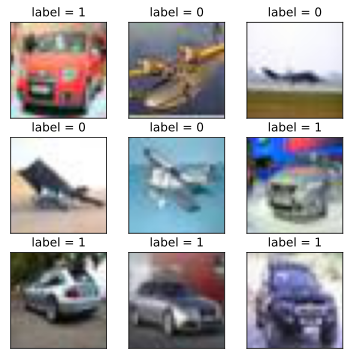

In [6]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.figure(figsize=(6,6)) 
for i,(img,label) in enumerate(ds3.unbatch().take(9)):
    ax=plt.subplot(3,3,i+1)
    ax.imshow(img.numpy())
    ax.set_title("label = %d"%label)
    ax.set_xticks([])
    ax.set_yticks([]) 
plt.show()

In [7]:
# 从csv文件构建数据管道
ds4 = tf.data.experimental.make_csv_dataset(
      file_pattern = ["./data/titanic/train.csv","./data/titanic/test.csv"],
      batch_size=3, 
      label_name="Survived",
      na_value="",
      num_epochs=1,
      ignore_errors=True)

for data,label in ds4.take(2):
    print(data,label)

OrderedDict([('PassengerId', <tf.Tensor: shape=(3,), dtype=int32, numpy=array([710, 655,  39], dtype=int32)>), ('Pclass', <tf.Tensor: shape=(3,), dtype=int32, numpy=array([3, 3, 3], dtype=int32)>), ('Name', <tf.Tensor: shape=(3,), dtype=string, numpy=
array([b'Moubarek, Master. Halim Gonios ("William George")',
       b'Hegarty, Miss. Hanora "Nora"',
       b'Vander Planke, Miss. Augusta Maria'], dtype=object)>), ('Sex', <tf.Tensor: shape=(3,), dtype=string, numpy=array([b'male', b'female', b'female'], dtype=object)>), ('Age', <tf.Tensor: shape=(3,), dtype=float32, numpy=array([ 0., 18., 18.], dtype=float32)>), ('SibSp', <tf.Tensor: shape=(3,), dtype=int32, numpy=array([1, 0, 2], dtype=int32)>), ('Parch', <tf.Tensor: shape=(3,), dtype=int32, numpy=array([1, 0, 0], dtype=int32)>), ('Ticket', <tf.Tensor: shape=(3,), dtype=string, numpy=array([b'2661', b'365226', b'345764'], dtype=object)>), ('Fare', <tf.Tensor: shape=(3,), dtype=float32, numpy=array([15.2458,  6.75  , 18.    ], dtype=flo

In [8]:
# 从文本文件构建数据管道

ds5 = tf.data.TextLineDataset(
    filenames = ["./data/titanic/train.csv","./data/titanic/test.csv"]
    ).skip(1) #略去第一行header

for line in ds5.take(5):
    print(line)

tf.Tensor(b'493,0,1,"Molson, Mr. Harry Markland",male,55.0,0,0,113787,30.5,C30,S', shape=(), dtype=string)
tf.Tensor(b'53,1,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0,1,0,PC 17572,76.7292,D33,C', shape=(), dtype=string)
tf.Tensor(b'388,1,2,"Buss, Miss. Kate",female,36.0,0,0,27849,13.0,,S', shape=(), dtype=string)
tf.Tensor(b'192,0,2,"Carbines, Mr. William",male,19.0,0,0,28424,13.0,,S', shape=(), dtype=string)
tf.Tensor(b'687,0,3,"Panula, Mr. Jaako Arnold",male,14.0,4,1,3101295,39.6875,,S', shape=(), dtype=string)


In [24]:
ds6 = tf.data.Dataset.list_files("./data/cifar2/train/*/*.jpg")
for file in ds6.take(5):
    print(file)

tf.Tensor(b'./data/cifar2/train/airplane/3977.jpg', shape=(), dtype=string)
tf.Tensor(b'./data/cifar2/train/automobile/1521.jpg', shape=(), dtype=string)
tf.Tensor(b'./data/cifar2/train/automobile/3352.jpg', shape=(), dtype=string)
tf.Tensor(b'./data/cifar2/train/airplane/3991.jpg', shape=(), dtype=string)
tf.Tensor(b'./data/cifar2/train/automobile/3383.jpg', shape=(), dtype=string)


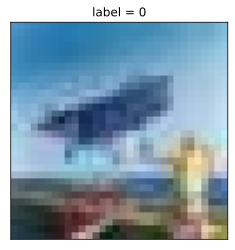

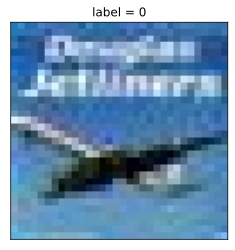

In [25]:
from matplotlib import pyplot as plt 
def load_image(img_path,size = (32,32)):
    label = 1 if tf.strings.regex_full_match(img_path,".*/automobile/.*") else 0
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img) #注意此处为jpeg格式
    img = tf.image.resize(img,size)
    return(img,label)

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
for i,(img,label) in enumerate(ds6.map(load_image).take(2)):
    plt.figure(i)
    plt.imshow((img/255.0).numpy())
    plt.title("label = %d"%label)
    plt.xticks([])
    plt.yticks([])

In [12]:
# 从tfrecords文件构建数据管道
import os
import numpy as np

# inpath：原始数据路径 outpath:TFRecord文件输出路径
def create_tfrecords(inpath,outpath): 
    writer = tf.io.TFRecordWriter(outpath)
    dirs = os.listdir(inpath)
    for index, name in enumerate(dirs):
        class_path = inpath +"/"+ name+"/"
        for img_name in os.listdir(class_path):
            img_path = class_path + img_name
            img = tf.io.read_file(img_path)
            #img = tf.image.decode_image(img)
            #img = tf.image.encode_jpeg(img) #统一成jpeg格式压缩
            example = tf.train.Example(
               features=tf.train.Features(feature={
                    'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[index])),
                    'img_raw': tf.train.Feature(bytes_list=tf.train.BytesList(value=[img.numpy()]))
               }))
            writer.write(example.SerializeToString())
    writer.close()
    
create_tfrecords("./data/cifar2/test/","./data/cifar2_test.tfrecords/")

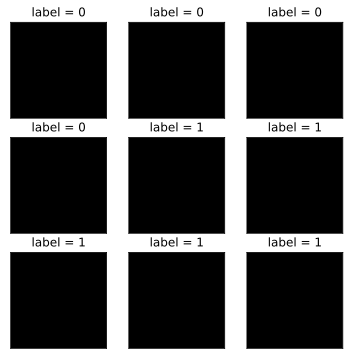

In [13]:
from matplotlib import pyplot as plt 

def parse_example(proto):
    description ={ 'img_raw' : tf.io.FixedLenFeature([], tf.string),
                   'label': tf.io.FixedLenFeature([], tf.int64)} 
    example = tf.io.parse_single_example(proto, description)
    img = tf.image.decode_jpeg(example["img_raw"])   #注意此处为jpeg格式
    img = tf.image.resize(img, (32,32))
    label = example["label"]
    return(img,label)

ds7 = tf.data.TFRecordDataset("./data/cifar2_test.tfrecords").map(parse_example).shuffle(3000)

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.figure(figsize=(6,6)) 
for i,(img,label) in enumerate(ds7.take(9)):
    ax=plt.subplot(3,3,i+1)
    ax.imshow((img/255.0).numpy())
    ax.set_title("label = %d"%label)
    ax.set_xticks([])
    ax.set_yticks([]) 
plt.show()

#### 应用数据转换


Dataset数据结构应用非常灵活，因为它本质上是一个Sequece序列，其每个元素可以是各种类型，例如可以是张量，列表，字典，也可以是Dataset。

Dataset包含了非常丰富的数据转换功能。

* map: 将转换函数映射到数据集每一个元素。

* flat_map: 将转换函数映射到数据集的每一个元素，并将嵌套的Dataset压平。

* interleave: 效果类似flat_map,但可以将不同来源的数据夹在一起。

* filter: 过滤掉某些元素。

* zip: 将两个长度相同的Dataset横向铰合。

* concatenate: 将两个Dataset纵向连接。

* reduce: 执行归并操作。

* batch : 构建批次，每次放一个批次。比原始数据增加一个维度。 其逆操作为unbatch。

* padded_batch: 构建批次，类似batch, 但可以填充到相同的形状。

* window :构建滑动窗口，返回Dataset of Dataset.

* shuffle: 数据顺序洗牌。

* repeat: 重复数据若干次，不带参数时，重复无数次。

* shard: 采样，从某个位置开始隔固定距离采样一个元素。

* take: 采样，从开始位置取前几个元素。

In [3]:
#map:将转换函数映射到数据集每一个元素

ds = tf.data.Dataset.from_tensor_slices(["hello world","hello China","hello Beijing"])
ds_map = ds.map(lambda x:tf.strings.split(x," "))
for x in ds_map:
    print(x)

tf.Tensor([b'hello' b'world'], shape=(2,), dtype=string)
tf.Tensor([b'hello' b'China'], shape=(2,), dtype=string)
tf.Tensor([b'hello' b'Beijing'], shape=(2,), dtype=string)


In [4]:
#flat_map:将转换函数映射到数据集的每一个元素，并将嵌套的Dataset压平。

ds = tf.data.Dataset.from_tensor_slices(["hello world","hello China","hello Beijing"])
ds_flatmap = ds.flat_map(lambda x:tf.data.Dataset.from_tensor_slices(tf.strings.split(x," ")))
for x in ds_flatmap:
    print(x)

tf.Tensor(b'hello', shape=(), dtype=string)
tf.Tensor(b'world', shape=(), dtype=string)
tf.Tensor(b'hello', shape=(), dtype=string)
tf.Tensor(b'China', shape=(), dtype=string)
tf.Tensor(b'hello', shape=(), dtype=string)
tf.Tensor(b'Beijing', shape=(), dtype=string)


In [5]:
# interleave: 效果类似flat_map,但可以将不同来源的数据夹在一起。

ds = tf.data.Dataset.from_tensor_slices(["hello world","hello China","hello Beijing"])
ds_interleave = ds.interleave(lambda x:tf.data.Dataset.from_tensor_slices(tf.strings.split(x," ")))
for x in ds_interleave:
    print(x)

tf.Tensor(b'hello', shape=(), dtype=string)
tf.Tensor(b'hello', shape=(), dtype=string)
tf.Tensor(b'hello', shape=(), dtype=string)
tf.Tensor(b'world', shape=(), dtype=string)
tf.Tensor(b'China', shape=(), dtype=string)
tf.Tensor(b'Beijing', shape=(), dtype=string)


In [6]:
#filter:过滤掉某些元素。

ds = tf.data.Dataset.from_tensor_slices(["hello world","hello China","hello Beijing"])
#找出含有字母a或B的元素
ds_filter = ds.filter(lambda x: tf.strings.regex_full_match(x, ".*[a|B].*"))
for x in ds_filter:
    print(x)

tf.Tensor(b'hello China', shape=(), dtype=string)
tf.Tensor(b'hello Beijing', shape=(), dtype=string)


In [7]:
#zip:将两个长度相同的Dataset横向铰合。

ds1 = tf.data.Dataset.range(0,3)
ds2 = tf.data.Dataset.range(3,6)
ds3 = tf.data.Dataset.range(6,9)
ds_zip = tf.data.Dataset.zip((ds1,ds2,ds3))
for x,y,z in ds_zip:
    print(x.numpy(),y.numpy(),z.numpy())

0 3 6
1 4 7
2 5 8


In [8]:
#condatenate:将两个Dataset纵向连接。

ds1 = tf.data.Dataset.range(0,3)
ds2 = tf.data.Dataset.range(3,6)
ds_concat = tf.data.Dataset.concatenate(ds1,ds2)
for x in ds_concat:
    print(x)

tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(5, shape=(), dtype=int64)


In [10]:
#reduce:执行归并操作。

ds = tf.data.Dataset.from_tensor_slices([1,2,3,4,5.0])
result = ds.reduce(5.0,lambda x,y:tf.add(x,y))
result

<tf.Tensor: shape=(), dtype=float32, numpy=20.0>

In [11]:
#batch:构建批次，每次放一个批次。比原始数据增加一个维度。 其逆操作为unbatch。 

ds = tf.data.Dataset.range(12)
ds_batch = ds.batch(4)
for x in ds_batch:
    print(x)

tf.Tensor([0 1 2 3], shape=(4,), dtype=int64)
tf.Tensor([4 5 6 7], shape=(4,), dtype=int64)
tf.Tensor([ 8  9 10 11], shape=(4,), dtype=int64)


In [12]:
#padded_batch:构建批次，类似batch, 但可以填充到相同的形状。

elements = [[1, 2],[3, 4, 5],[6, 7],[8]]
ds = tf.data.Dataset.from_generator(lambda: iter(elements), tf.int32)

ds_padded_batch = ds.padded_batch(2,padded_shapes = [4,])
for x in ds_padded_batch:
    print(x)    

tf.Tensor(
[[1 2 0 0]
 [3 4 5 0]], shape=(2, 4), dtype=int32)
tf.Tensor(
[[6 7 0 0]
 [8 0 0 0]], shape=(2, 4), dtype=int32)


In [13]:
#window:构建滑动窗口，返回Dataset of Dataset.

ds = tf.data.Dataset.range(12)
#window返回的是Dataset of Dataset,可以用flat_map压平
ds_window = ds.window(3, shift=1).flat_map(lambda x: x.batch(3,drop_remainder=True)) 
for x in ds_window:
    print(x)

tf.Tensor([0 1 2], shape=(3,), dtype=int64)
tf.Tensor([1 2 3], shape=(3,), dtype=int64)
tf.Tensor([2 3 4], shape=(3,), dtype=int64)
tf.Tensor([3 4 5], shape=(3,), dtype=int64)
tf.Tensor([4 5 6], shape=(3,), dtype=int64)
tf.Tensor([5 6 7], shape=(3,), dtype=int64)
tf.Tensor([6 7 8], shape=(3,), dtype=int64)
tf.Tensor([7 8 9], shape=(3,), dtype=int64)
tf.Tensor([ 8  9 10], shape=(3,), dtype=int64)
tf.Tensor([ 9 10 11], shape=(3,), dtype=int64)


In [14]:
#shuffle:数据顺序洗牌。

ds = tf.data.Dataset.range(12)
ds_shuffle = ds.shuffle(buffer_size = 5)
for x in ds_shuffle:
    print(x)

tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(7, shape=(), dtype=int64)
tf.Tensor(10, shape=(), dtype=int64)
tf.Tensor(6, shape=(), dtype=int64)
tf.Tensor(11, shape=(), dtype=int64)
tf.Tensor(8, shape=(), dtype=int64)
tf.Tensor(5, shape=(), dtype=int64)
tf.Tensor(9, shape=(), dtype=int64)


In [15]:
#repeat:重复数据若干次，不带参数时，重复无数次。

ds = tf.data.Dataset.range(3)
ds_repeat = ds.repeat(3)
for x in ds_repeat:
    print(x)

tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)


In [16]:
#shard:采样，从某个位置开始隔固定距离采样一个元素。

ds = tf.data.Dataset.range(12)
ds_shard = ds.shard(3,index = 1)

for x in ds_shard:
    print(x)

tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(7, shape=(), dtype=int64)
tf.Tensor(10, shape=(), dtype=int64)


In [17]:
#take:采样，从开始位置取前几个元素。

ds = tf.data.Dataset.range(12)
ds_take = ds.take(3)

list(ds_take.as_numpy_iterator())

[0, 1, 2]

#### 提升管道性能


训练深度学习模型常常会非常耗时。

模型训练的耗时主要来自于两个部分，一部分来自**数据准备**，另一部分来自**参数迭代**。

参数迭代过程的耗时通常依赖于GPU来提升。

而数据准备过程的耗时则可以通过构建高效的数据管道进行提升。

以下是一些构建高效数据管道的建议。

* 使用 prefetch 方法让数据准备和参数迭代两个过程相互并行。

* 使用 interleave 方法可以让数据读取过程多进程执行,并将不同来源数据夹在一起。

* 使用 map 时设置num_parallel_calls 让数据转换过程多进程执行。

* 使用 cache 方法让数据在第一个epoch后缓存到内存中，仅限于数据集不大情形。

* 使用 map转换时，先batch, 然后采用向量化的转换方法对每个batch进行转换。

**1，使用 prefetch 方法让数据准备和参数迭代两个过程相互并行。**

In [18]:
import tensorflow as tf

#打印时间分割线
@tf.function
def printbar():
    ts = tf.timestamp()
    today_ts = ts%(24*60*60)

    hour = tf.cast(today_ts//3600+8,tf.int32)%tf.constant(24)
    minite = tf.cast((today_ts%3600)//60,tf.int32)
    second = tf.cast(tf.floor(today_ts%60),tf.int32)
    
    def timeformat(m):
        if tf.strings.length(tf.strings.format("{}",m))==1:
            return(tf.strings.format("0{}",m))
        else:
            return(tf.strings.format("{}",m))
    
    timestring = tf.strings.join([timeformat(hour),timeformat(minite),
                timeformat(second)],separator = ":")
    tf.print("=========="*8,end = "")
    tf.print(timestring)

In [19]:
import time

# 数据准备和参数迭代两个过程默认情况下是串行的。

# 模拟数据准备
def generator():
    for i in range(10):
        #假设每次准备数据需要2s
        time.sleep(2) 
        yield i 
ds = tf.data.Dataset.from_generator(generator,output_types = (tf.int32))

# 模拟参数迭代
def train_step():
    #假设每一步训练需要1s
    time.sleep(1) 

In [20]:
# 训练过程预计耗时 10*2+10*1 = 30s
printbar()
tf.print(tf.constant("start training..."))
for x in ds:
    train_step()  
printbar()
tf.print(tf.constant("end training..."))

================================================================================14:10:44
start training...
================================================================================14:11:19
end training...


In [21]:
# 使用 prefetch 方法让数据准备和参数迭代两个过程相互并行。

# 训练过程预计耗时 max(10*2,10*1) = 20s
printbar()
tf.print(tf.constant("start training with prefetch..."))

# tf.data.experimental.AUTOTUNE 可以让程序自动选择合适的参数
for x in ds.prefetch(buffer_size = tf.data.experimental.AUTOTUNE):
    train_step()  
    
printbar()
tf.print(tf.constant("end training..."))

================================================================================14:12:10
start training with prefetch...
================================================================================14:12:31
end training...


In [22]:
# 使用 interleave 方法可以让数据读取过程多进程执行,并将不同来源数据夹在一起。

ds_files = tf.data.Dataset.list_files("./data/titanic/*.csv")
ds = ds_files.flat_map(lambda x:tf.data.TextLineDataset(x).skip(1))
for line in ds.take(4):
    print(line)

tf.Tensor(b'181,0,3,"Sage, Miss. Constance Gladys",female,,8,2,CA. 2343,69.55,,S', shape=(), dtype=string)
tf.Tensor(b'405,0,3,"Oreskovic, Miss. Marija",female,20.0,0,0,315096,8.6625,,S', shape=(), dtype=string)
tf.Tensor(b'635,0,3,"Skoog, Miss. Mabel",female,9.0,3,2,347088,27.9,,S', shape=(), dtype=string)
tf.Tensor(b'701,1,1,"Astor, Mrs. John Jacob (Madeleine Talmadge Force)",female,18.0,1,0,PC 17757,227.525,C62 C64,C', shape=(), dtype=string)


In [23]:
ds_files = tf.data.Dataset.list_files("./data/titanic/*.csv")
ds = ds_files.interleave(lambda x:tf.data.TextLineDataset(x).skip(1))
for line in ds.take(8):
    print(line)

tf.Tensor(b'493,0,1,"Molson, Mr. Harry Markland",male,55.0,0,0,113787,30.5,C30,S', shape=(), dtype=string)
tf.Tensor(b'181,0,3,"Sage, Miss. Constance Gladys",female,,8,2,CA. 2343,69.55,,S', shape=(), dtype=string)
tf.Tensor(b'53,1,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0,1,0,PC 17572,76.7292,D33,C', shape=(), dtype=string)
tf.Tensor(b'405,0,3,"Oreskovic, Miss. Marija",female,20.0,0,0,315096,8.6625,,S', shape=(), dtype=string)
tf.Tensor(b'388,1,2,"Buss, Miss. Kate",female,36.0,0,0,27849,13.0,,S', shape=(), dtype=string)
tf.Tensor(b'635,0,3,"Skoog, Miss. Mabel",female,9.0,3,2,347088,27.9,,S', shape=(), dtype=string)
tf.Tensor(b'192,0,2,"Carbines, Mr. William",male,19.0,0,0,28424,13.0,,S', shape=(), dtype=string)
tf.Tensor(b'701,1,1,"Astor, Mrs. John Jacob (Madeleine Talmadge Force)",female,18.0,1,0,PC 17757,227.525,C62 C64,C', shape=(), dtype=string)


In [26]:
# 使用 map 时设置num_parallel_calls 让数据转换过程多进行执行。

ds = tf.data.Dataset.list_files("./data/cifar2/train/*/*.jpg")
def load_image(img_path,size = (32,32)):
    label = 1 if tf.strings.regex_full_match(img_path,".*/automobile/.*") else 0
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img) #注意此处为jpeg格式
    img = tf.image.resize(img,size)
    return(img,label)


In [27]:
#单进程转换
printbar()
tf.print(tf.constant("start transformation..."))

ds_map = ds.map(load_image)
for _ in ds_map:
    pass

printbar()
tf.print(tf.constant("end transformation..."))

================================================================================14:15:00
start transformation...
================================================================================14:15:13
end transformation...


In [28]:
#多进程转换
printbar()
tf.print(tf.constant("start parallel transformation..."))

ds_map_parallel = ds.map(load_image,num_parallel_calls = tf.data.experimental.AUTOTUNE)
for _ in ds_map_parallel:
    pass

printbar()
tf.print(tf.constant("end parallel transformation..."))

================================================================================14:15:31
start parallel transformation...
================================================================================14:15:32
end parallel transformation...


In [29]:
# 使用 cache 方法让数据在第一个epoch后缓存到内存中，仅限于数据集不大情形。


import time

# 模拟数据准备
def generator():
    for i in range(5):
        #假设每次准备数据需要2s
        time.sleep(2) 
        yield i 
ds = tf.data.Dataset.from_generator(generator,output_types = (tf.int32))

# 模拟参数迭代
def train_step():
    #假设每一步训练需要0s
    pass

# 训练过程预计耗时 (5*2+5*0)*3 = 30s
printbar()
tf.print(tf.constant("start training..."))
for epoch in tf.range(3):
    for x in ds:
        train_step()  
    printbar()
    tf.print("epoch =",epoch," ended")
printbar()
tf.print(tf.constant("end training..."))


================================================================================14:16:01
start training...
================================================================================14:16:11
epoch = 0  ended
================================================================================14:16:21
epoch = 1  ended
================================================================================14:16:31
epoch = 2  ended
================================================================================14:16:31
end training...


In [30]:
import time

# 模拟数据准备
def generator():
    for i in range(5):
        #假设每次准备数据需要2s
        time.sleep(2) 
        yield i 

# 使用 cache 方法让数据在第一个epoch后缓存到内存中，仅限于数据集不大情形。
ds = tf.data.Dataset.from_generator(generator,output_types = (tf.int32)).cache()

# 模拟参数迭代
def train_step():
    #假设每一步训练需要0s
    time.sleep(0) 

# 训练过程预计耗时 (5*2+5*0)+(5*0+5*0)*2 = 10s
printbar()
tf.print(tf.constant("start training..."))
for epoch in tf.range(3):
    for x in ds:
        train_step()  
    printbar()
    tf.print("epoch =",epoch," ended")
printbar()
tf.print(tf.constant("end training..."))

================================================================================14:16:37
start training...
================================================================================14:16:47
epoch = 0  ended
================================================================================14:16:47
epoch = 1  ended
================================================================================14:16:47
epoch = 2  ended
================================================================================14:16:47
end training...


In [32]:
# 使用 map转换时，先batch, 然后采用向量化的转换方法对每个batch进行转换

#先map后batch
ds = tf.data.Dataset.range(100000)
ds_map_batch = ds.map(lambda x:x**2).batch(20)

printbar()
tf.print(tf.constant("start scalar transformation..."))
for x in ds_map_batch:
    pass
printbar()
tf.print(tf.constant("end scalar transformation..."))

================================================================================14:17:40
start scalar transformation...
================================================================================14:17:45
end scalar transformation...


In [33]:
#先batch后map
ds = tf.data.Dataset.range(100000)
ds_batch_map = ds.batch(20).map(lambda x:x**2)

printbar()
tf.print(tf.constant("start vector transformation..."))
for x in ds_batch_map:
    pass
printbar()
tf.print(tf.constant("end vector transformation..."))

================================================================================14:17:45
start vector transformation...
================================================================================14:17:46
end vector transformation...


### 特征列feature_column

特征列 通常用于对结构化数据实施特征工程时候使用，图像或者文本数据一般不会用到特征列。


#### 特征列用法概述


使用特征列可以将类别特征转换为one-hot编码特征，将连续特征构建分桶特征，以及对多个特征生成交叉特征等等。


要创建特征列，请调用 tf.feature_column 模块的函数。该模块中常用的九个函数如下图所示，所有九个函数都会返回一个 Categorical-Column 或一个 
Dense-Column 对象，但却不会返回 bucketized_column，后者继承自这两个类。

注意：所有的Catogorical Column类型最终都要通过indicator_column转换成Dense Column类型才能传入模型！


![](./data/特征列9种.jpg)

* numeric_column 数值列，最常用。


* bucketized_column 分桶列，由数值列生成，可以由一个数值列出多个特征，one-hot编码。


* categorical_column_with_identity 分类标识列，one-hot编码，相当于分桶列每个桶为1个整数的情况。


* categorical_column_with_vocabulary_list 分类词汇列，one-hot编码，由list指定词典。


* categorical_column_with_vocabulary_file 分类词汇列，由文件file指定词典。


* categorical_column_with_hash_bucket 哈希列，整数或词典较大时采用。


* indicator_column 指标列，由Categorical Column生成，one-hot编码


* embedding_column 嵌入列，由Categorical Column生成，嵌入矢量分布参数需要学习。嵌入矢量维数建议取类别数量的 4 次方根。


* crossed_column 交叉列，可以由除categorical_column_with_hash_bucket的任意分类列构成。

#### 特征列使用范例


以下是一个使用特征列解决Titanic生存问题的完整范例。

In [34]:
import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers,models


#打印日志
def printlog(info):
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*8 + "%s"%nowtime)
    print(info+'...\n\n')

In [35]:
#================================================================================
# 一，构建数据管道
#================================================================================
printlog("step1: prepare dataset...")


dftrain_raw = pd.read_csv("./data/titanic/train.csv")
dftest_raw = pd.read_csv("./data/titanic/test.csv")

dfraw = pd.concat([dftrain_raw,dftest_raw])

def prepare_dfdata(dfraw):
    dfdata = dfraw.copy()
    dfdata.columns = [x.lower() for x in dfdata.columns]
    dfdata = dfdata.rename(columns={'survived':'label'})
    dfdata = dfdata.drop(['passengerid','name'],axis = 1)
    for col,dtype in dict(dfdata.dtypes).items():
        # 判断是否包含缺失值
        if dfdata[col].hasnans:
            # 添加标识是否缺失列
            dfdata[col + '_nan'] = pd.isna(dfdata[col]).astype('int32')
            # 填充
            if dtype not in [np.object,np.str,np.unicode]:
                dfdata[col].fillna(dfdata[col].mean(),inplace = True)
            else:
                dfdata[col].fillna('',inplace = True)
    return(dfdata)

dfdata = prepare_dfdata(dfraw)
dftrain = dfdata.iloc[0:len(dftrain_raw),:]
dftest = dfdata.iloc[len(dftrain_raw):,:]



# 从 dataframe 导入数据 
def df_to_dataset(df, shuffle=True, batch_size=32):
    dfdata = df.copy()
    if 'label' not in dfdata.columns:
        ds = tf.data.Dataset.from_tensor_slices(dfdata.to_dict(orient = 'list'))
    else: 
        labels = dfdata.pop('label')
        ds = tf.data.Dataset.from_tensor_slices((dfdata.to_dict(orient = 'list'), labels))  
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dfdata))
    ds = ds.batch(batch_size)
    return ds

ds_train = df_to_dataset(dftrain)
ds_test = df_to_dataset(dftest)


================================================================================2021-01-05 06:22:15
step1: prepare dataset......




In [36]:
#================================================================================
# 二，定义特征列
#================================================================================
printlog("step2: make feature columns...")

feature_columns = []

# 数值列
for col in ['age','fare','parch','sibsp'] + [
    c for c in dfdata.columns if c.endswith('_nan')]:
    feature_columns.append(tf.feature_column.numeric_column(col))

# 分桶列
age = tf.feature_column.numeric_column('age')
age_buckets = tf.feature_column.bucketized_column(age, 
             boundaries=[18, 25, 30, 35, 40, 45, 50, 55, 60, 65])
feature_columns.append(age_buckets)

# 类别列
# 注意：所有的Catogorical Column类型最终都要通过indicator_column转换成Dense Column类型才能传入模型！！
sex = tf.feature_column.indicator_column(
      tf.feature_column.categorical_column_with_vocabulary_list(
      key='sex',vocabulary_list=["male", "female"]))
feature_columns.append(sex)

pclass = tf.feature_column.indicator_column(
      tf.feature_column.categorical_column_with_vocabulary_list(
      key='pclass',vocabulary_list=[1,2,3]))
feature_columns.append(pclass)

ticket = tf.feature_column.indicator_column(
     tf.feature_column.categorical_column_with_hash_bucket('ticket',3))
feature_columns.append(ticket)

embarked = tf.feature_column.indicator_column(
      tf.feature_column.categorical_column_with_vocabulary_list(
      key='embarked',vocabulary_list=['S','C','B']))
feature_columns.append(embarked)

# 嵌入列
cabin = tf.feature_column.embedding_column(
    tf.feature_column.categorical_column_with_hash_bucket('cabin',32),2)
feature_columns.append(cabin)

# 交叉列
pclass_cate = tf.feature_column.categorical_column_with_vocabulary_list(
          key='pclass',vocabulary_list=[1,2,3])

crossed_feature = tf.feature_column.indicator_column(
    tf.feature_column.crossed_column([age_buckets, pclass_cate],hash_bucket_size=15))

feature_columns.append(crossed_feature)


================================================================================2021-01-05 06:23:03
step2: make feature columns......




In [37]:
#================================================================================
# 三，定义模型
#================================================================================
printlog("step3: define model...")

tf.keras.backend.clear_session()
model = tf.keras.Sequential([
  layers.DenseFeatures(feature_columns), #将特征列放入到tf.keras.layers.DenseFeatures中!!!
  layers.Dense(64, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])


================================================================================2021-01-05 06:23:56
step3: define model......




In [38]:
#================================================================================
# 四，训练模型
#================================================================================
printlog("step4: train model...")

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(ds_train,
          validation_data=ds_test,
          epochs=10)


================================================================================2021-01-05 06:24:30
step4: train model......


Epoch 1/10
23/23 [==============================] - 1s 25ms/step - loss: 1.0971 - accuracy: 0.5042 - val_loss: 0.6615 - val_accuracy: 0.6480
Epoch 2/10
23/23 [==============================] - 0s 7ms/step - loss: 0.6860 - accuracy: 0.6840 - val_loss: 0.5912 - val_accuracy: 0.7598
Epoch 3/10
23/23 [==============================] - 0s 7ms/step - loss: 0.5886 - accuracy: 0.7079 - val_loss: 0.5607 - val_accuracy: 0.7151
Epoch 4/10
23/23 [==============================] - 0s 7ms/step - loss: 0.5782 - accuracy: 0.7022 - val_loss: 0.5444 - val_accuracy: 0.7151
Epoch 5/10
23/23 [==============================] - 0s 7ms/step - loss: 0.5661 - accuracy: 0.7093 - val_loss: 0.5367 - val_accuracy: 0.7486
Epoch 6/10
23/23 [==============================] - 0s 6ms/step - loss: 0.5498 - accuracy: 0.7275 - val_loss: 0.5478 - val_accuracy: 0.7263
Epoch 7/10
23/23 [=============


================================================================================2021-01-05 06:24:45
step5: eval model......


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_features (DenseFeature multiple                  64        
_________________________________________________________________
dense (Dense)                multiple                  3008      
_________________________________________________________________
dense_1 (Dense)              multiple                  4160      
_________________________________________________________________
dense_2 (Dense)              multiple                  65        
Total params: 7,297
Trainable params: 7,297
Non-trainable params: 0
_________________________________________________________________


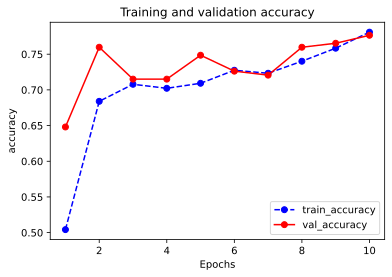

In [39]:
#================================================================================
# 五，评估模型
#================================================================================
printlog("step5: eval model...")

model.summary()


%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

plot_metric(history,"accuracy")

### 激活函数activation

激活函数在深度学习中扮演着非常重要的角色，它给网络赋予了非线性，从而使得神经网络能够拟合任意复杂的函数。

如果没有激活函数，无论多复杂的网络，都等价于单一的线性变换，无法对非线性函数进行拟合。

目前，深度学习中最流行的激活函数为 relu, 但也有些新推出的激活函数，例如 swish、GELU 据称效果优于relu激活函数。

激活函数的综述介绍可以参考下面两篇文章。

[《一文概览深度学习中的激活函数》](https://zhuanlan.zhihu.com/p/98472075)

https://zhuanlan.zhihu.com/p/98472075

[《从ReLU到GELU,一文概览神经网络中的激活函数》](https://zhuanlan.zhihu.com/p/98863801)

https://zhuanlan.zhihu.com/p/98863801



#### 常用激活函数


* tf.nn.sigmoid：将实数压缩到0到1之间，一般只在二分类的最后输出层使用。主要缺陷为存在梯度消失问题，计算复杂度高，输出不以0为中心。

![](./data/sigmoid.png)

* tf.nn.softmax：sigmoid的多分类扩展，一般只在多分类问题的最后输出层使用。

![](./data/softmax说明.jpg)

* tf.nn.tanh：将实数压缩到-1到1之间，输出期望为0。主要缺陷为存在梯度消失问题，计算复杂度高。

![](./data/tanh.png)

* tf.nn.relu：修正线性单元，最流行的激活函数。一般隐藏层使用。主要缺陷是：输出不以0为中心，输入小于0时存在梯度消失问题(死亡relu)。

![](./data/relu.png)

* tf.nn.leaky_relu：对修正线性单元的改进，解决了死亡relu问题。

![](./data/leaky_relu.png)

* tf.nn.elu：指数线性单元。对relu的改进，能够缓解死亡relu问题。

![](./data/elu.png)

* tf.nn.selu：扩展型指数线性单元。在权重用tf.keras.initializers.lecun_normal初始化前提下能够对神经网络进行自归一化。不可能出现梯度爆炸或者梯度消失问题。需要和Dropout的变种AlphaDropout一起使用。

![](./data/selu.png)

* tf.nn.swish：自门控激活函数。谷歌出品，相关研究指出用swish替代relu将获得轻微效果提升。

![](./data/swish.png)

* gelu：高斯误差线性单元激活函数。在Transformer中表现最好。tf.nn模块尚没有实现该函数。

![](./data/gelu.png)

#### 在模型中使用激活函数


在keras模型中使用激活函数一般有两种方式，一种是作为某些层的activation参数指定，另一种是显式添加layers.Activation激活层。

In [40]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers,models

tf.keras.backend.clear_session()

model = models.Sequential()
model.add(layers.Dense(32,input_shape = (None,16),activation = tf.nn.relu)) #通过activation参数指定
model.add(layers.Dense(10))
model.add(layers.Activation(tf.nn.softmax))  # 显式添加layers.Activation激活层
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, None, 32)          544       
_________________________________________________________________
dense_1 (Dense)              (None, None, 10)          330       
_________________________________________________________________
activation (Activation)      (None, None, 10)          0         
Total params: 874
Trainable params: 874
Non-trainable params: 0
_________________________________________________________________


### 模型层layers

深度学习模型一般由各种模型层组合而成。

tf.keras.layers内置了非常丰富的各种功能的模型层。例如，

layers.Dense,layers.Flatten,layers.Input,layers.DenseFeature,layers.Dropout

layers.Conv2D,layers.MaxPooling2D,layers.Conv1D

layers.Embedding,layers.GRU,layers.LSTM,layers.Bidirectional等等。

如果这些内置模型层不能够满足需求，我们也可以通过编写tf.keras.Lambda匿名模型层或继承tf.keras.layers.Layer基类构建自定义的模型层。

其中tf.keras.Lambda匿名模型层只适用于构造没有学习参数的模型层。



#### 内置模型层


一些常用的内置模型层简单介绍如下。

**基础层**

* Dense：密集连接层。参数个数 = 输入层特征数× 输出层特征数(weight)＋ 输出层特征数(bias)

* Activation：激活函数层。一般放在Dense层后面，等价于在Dense层中指定activation。

* Dropout：随机置零层。训练期间以一定几率将输入置0，一种正则化手段。

* BatchNormalization：批标准化层。通过线性变换将输入批次缩放平移到稳定的均值和标准差。可以增强模型对输入不同分布的适应性，加快模型训练速度，有轻微正则化效果。一般在激活函数之前使用。

* SpatialDropout2D：空间随机置零层。训练期间以一定几率将整个特征图置0，一种正则化手段，有利于避免特征图之间过高的相关性。

* Input：输入层。通常使用Functional API方式构建模型时作为第一层。

* DenseFeature：特征列接入层，用于接收一个特征列列表并产生一个密集连接层。

* Flatten：压平层，用于将多维张量压成一维。

* Reshape：形状重塑层，改变输入张量的形状。

* Concatenate：拼接层，将多个张量在某个维度上拼接。

* Add：加法层。

* Subtract： 减法层。

* Maximum：取最大值层。

* Minimum：取最小值层。


**卷积网络相关层**

* Conv1D：普通一维卷积，常用于文本。参数个数 = 输入通道数×卷积核尺寸(如3)×卷积核个数

* Conv2D：普通二维卷积，常用于图像。参数个数 = 输入通道数×卷积核尺寸(如3乘3)×卷积核个数

* Conv3D：普通三维卷积，常用于视频。参数个数 = 输入通道数×卷积核尺寸(如3乘3乘3)×卷积核个数

* SeparableConv2D：二维深度可分离卷积层。不同于普通卷积同时对区域和通道操作，深度可分离卷积先操作区域，再操作通道。即先对每个通道做独立卷积操作区域，再用1乘1卷积跨通道组合操作通道。参数个数 = 输入通道数×卷积核尺寸 + 输入通道数×1×1×输出通道数。深度可分离卷积的参数数量一般远小于普通卷积，效果一般也更好。

* DepthwiseConv2D：二维深度卷积层。仅有SeparableConv2D前半部分操作，即只操作区域，不操作通道，一般输出通道数和输入通道数相同，但也可以通过设置depth_multiplier让输出通道为输入通道的若干倍数。输出通道数 = 输入通道数 × depth_multiplier。参数个数 = 输入通道数×卷积核尺寸× depth_multiplier。

* Conv2DTranspose：二维卷积转置层，俗称反卷积层。并非卷积的逆操作，但在卷积核相同的情况下，当其输入尺寸是卷积操作输出尺寸的情况下，卷积转置的输出尺寸恰好是卷积操作的输入尺寸。

* LocallyConnected2D: 二维局部连接层。类似Conv2D，唯一的差别是没有空间上的权值共享，所以其参数个数远高于二维卷积。

* MaxPool2D: 二维最大池化层。也称作下采样层。池化层无可训练参数，主要作用是降维。

* AveragePooling2D: 二维平均池化层。

* GlobalMaxPool2D: 全局最大池化层。每个通道仅保留一个值。一般从卷积层过渡到全连接层时使用，是Flatten的替代方案。

* GlobalAvgPool2D: 全局平均池化层。每个通道仅保留一个值。


**循环网络相关层**

* Embedding：嵌入层。一种比Onehot更加有效的对离散特征进行编码的方法。一般用于将输入中的单词映射为稠密向量。嵌入层的参数需要学习。

* LSTM：长短记忆循环网络层。最普遍使用的循环网络层。具有携带轨道，遗忘门，更新门，输出门。可以较为有效地缓解梯度消失问题，从而能够适用长期依赖问题。设置return_sequences = True时可以返回各个中间步骤输出，否则只返回最终输出。

* GRU：门控循环网络层。LSTM的低配版，不具有携带轨道，参数数量少于LSTM，训练速度更快。

* SimpleRNN：简单循环网络层。容易存在梯度消失，不能够适用长期依赖问题。一般较少使用。

* ConvLSTM2D：卷积长短记忆循环网络层。结构上类似LSTM，但对输入的转换操作和对状态的转换操作都是卷积运算。

* Bidirectional：双向循环网络包装器。可以将LSTM，GRU等层包装成双向循环网络。从而增强特征提取能力。

* RNN：RNN基本层。接受一个循环网络单元或一个循环单元列表，通过调用tf.keras.backend.rnn函数在序列上进行迭代从而转换成循环网络层。

* LSTMCell：LSTM单元。和LSTM在整个序列上迭代相比，它仅在序列上迭代一步。可以简单理解LSTM即RNN基本层包裹LSTMCell。

* GRUCell：GRU单元。和GRU在整个序列上迭代相比，它仅在序列上迭代一步。

* SimpleRNNCell：SimpleRNN单元。和SimpleRNN在整个序列上迭代相比，它仅在序列上迭代一步。

* AbstractRNNCell：抽象RNN单元。通过对它的子类化用户可以自定义RNN单元，再通过RNN基本层的包裹实现用户自定义循环网络层。

* Attention：Dot-product类型注意力机制层。可以用于构建注意力模型。

* AdditiveAttention：Additive类型注意力机制层。可以用于构建注意力模型。

* TimeDistributed：时间分布包装器。包装后可以将Dense、Conv2D等作用到每一个时间片段上。



#### 自定义模型层


如果自定义模型层没有需要被训练的参数，一般推荐使用Lamda层实现。

如果自定义模型层有需要被训练的参数，则可以通过对Layer基类子类化实现。

Lambda层由于没有需要被训练的参数，只需要定义正向传播逻辑即可，使用比Layer基类子类化更加简单。

Lambda层的正向逻辑可以使用Python的lambda函数来表达，也可以用def关键字定义函数来表达。

In [41]:
import tensorflow as tf
from tensorflow.keras import layers,models,regularizers

mypower = layers.Lambda(lambda x:tf.math.pow(x,2))
mypower(tf.range(5))

<tf.Tensor: shape=(5,), dtype=int32, numpy=array([ 0,  1,  4,  9, 16], dtype=int32)>

Layer的子类化一般需要重新实现初始化方法，Build方法和Call方法。下面是一个简化的线性层的范例，类似Dense.

In [42]:
class Linear(layers.Layer):
    def __init__(self, units=32, **kwargs):
        super(Linear, self).__init__(**kwargs)
        self.units = units
    
    #build方法一般定义Layer需要被训练的参数。    
    def build(self, input_shape): 
        self.w = self.add_weight("w",shape=(input_shape[-1], self.units),
                                 initializer='random_normal',
                                 trainable=True) #注意必须要有参数名称"w",否则会报错
        self.b = self.add_weight("b",shape=(self.units,),
                                 initializer='random_normal',
                                 trainable=True)
        super(Linear,self).build(input_shape) # 相当于设置self.built = True

    #call方法一般定义正向传播运算逻辑，__call__方法调用了它。  
    @tf.function
    def call(self, inputs): 
        return tf.matmul(inputs, self.w) + self.b
    
    #如果要让自定义的Layer通过Functional API 组合成模型时可以被保存成h5模型，需要自定义get_config方法。
    def get_config(self):  
        config = super(Linear, self).get_config()
        config.update({'units': self.units})
        return config

In [43]:
linear = Linear(units = 8)
print(linear.built)
#指定input_shape，显式调用build方法，第0维代表样本数量，用None填充
linear.build(input_shape = (None,16)) 
print(linear.built)

False
True


In [44]:
linear = Linear(units = 8)
print(linear.built)
linear.build(input_shape = (None,16)) 
print(linear.compute_output_shape(input_shape = (None,16)))

False
(None, 8)


In [45]:
linear = Linear(units = 16)
print(linear.built)
#如果built = False，调用__call__时会先调用build方法, 再调用call方法。
linear(tf.random.uniform((100,64))) 
print(linear.built)
config = linear.get_config()
print(config)

False
True
{'name': 'linear_2', 'trainable': True, 'dtype': 'float32', 'units': 16}


In [46]:
tf.keras.backend.clear_session()

model = models.Sequential()
#注意该处的input_shape会被模型加工，无需使用None代表样本数量维
model.add(Linear(units = 1,input_shape = (2,)))  
print("model.input_shape: ",model.input_shape)
print("model.output_shape: ",model.output_shape)
model.summary()

model.input_shape:  (None, 2)
model.output_shape:  (None, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
linear (Linear)              (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [47]:
model.compile(optimizer = "sgd",loss = "mse",metrics=["mae"])
print(model.predict(tf.constant([[3.0,2.0],[4.0,5.0]])))


# 保存成 h5模型
model.save("./data/linear_model.h5",save_format = "h5")
model_loaded_keras = tf.keras.models.load_model(
    "./data/linear_model.h5",custom_objects={"Linear":Linear})
print(model_loaded_keras.predict(tf.constant([[3.0,2.0],[4.0,5.0]])))


# 保存成 tf模型
model.save("./data/linear_model",save_format = "tf")
model_loaded_tf = tf.keras.models.load_model("./data/linear_model")
print(model_loaded_tf.predict(tf.constant([[3.0,2.0],[4.0,5.0]])))

[[-0.04869205]
 [-0.06376053]]
[[-0.04869205]
 [-0.06376053]]
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./data/linear_model/assets
[[-0.04869205]
 [-0.06376053]]


### 损失函数losses

一般来说，监督学习的目标函数由损失函数和正则化项组成。（Objective = Loss + Regularization）

对于keras模型，目标函数中的正则化项一般在各层中指定，例如使用Dense的 kernel_regularizer 和 bias_regularizer等参数指定权重使用l1或者l2正则化项，此外还可以用kernel_constraint 和 bias_constraint等参数约束权重的取值范围，这也是一种正则化手段。

损失函数在模型编译时候指定。对于回归模型，通常使用的损失函数是均方损失函数 mean_squared_error。

对于二分类模型，通常使用的是二元交叉熵损失函数 binary_crossentropy。

对于多分类模型，如果label是one-hot编码的，则使用类别交叉熵损失函数 categorical_crossentropy。如果label是类别序号编码的，则需要使用稀疏类别交叉熵损失函数 sparse_categorical_crossentropy。

如果有需要，也可以自定义损失函数，自定义损失函数需要接收两个张量y_true,y_pred作为输入参数，并输出一个标量作为损失函数值。

In [48]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers,models,losses,regularizers,constraints

#### 损失函数和正则化项

In [49]:
tf.keras.backend.clear_session()

model = models.Sequential()
model.add(layers.Dense(64, input_dim=64,
                kernel_regularizer=regularizers.l2(0.01), 
                activity_regularizer=regularizers.l1(0.01),
                kernel_constraint = constraints.MaxNorm(max_value=2, axis=0))) 
model.add(layers.Dense(10,
        kernel_regularizer=regularizers.l1_l2(0.01,0.01),activation = "sigmoid"))
model.compile(optimizer = "rmsprop",
        loss = "binary_crossentropy",metrics = ["AUC"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650       
Total params: 4,810
Trainable params: 4,810
Non-trainable params: 0
_________________________________________________________________


#### 内置损失函数


内置的损失函数一般有类的实现和函数的实现两种形式。

如：CategoricalCrossentropy 和 categorical_crossentropy 都是类别交叉熵损失函数，前者是类的实现形式，后者是函数的实现形式。

常用的一些内置损失函数说明如下。

* mean_squared_error（均方误差损失，用于回归，简写为 mse, 类与函数实现形式分别为 MeanSquaredError 和 MSE）

* mean_absolute_error (平均绝对值误差损失，用于回归，简写为 mae, 类与函数实现形式分别为 MeanAbsoluteError 和 MAE)

* mean_absolute_percentage_error (平均百分比误差损失，用于回归，简写为 mape, 类与函数实现形式分别为 MeanAbsolutePercentageError 和 MAPE)

* Huber(Huber损失，只有类实现形式，用于回归，介于mse和mae之间，对异常值比较鲁棒，相对mse有一定的优势)

* binary_crossentropy(二元交叉熵，用于二分类，类实现形式为 BinaryCrossentropy)

* categorical_crossentropy(类别交叉熵，用于多分类，要求label为onehot编码，类实现形式为 CategoricalCrossentropy)

* sparse_categorical_crossentropy(稀疏类别交叉熵，用于多分类，要求label为序号编码形式，类实现形式为 SparseCategoricalCrossentropy)

* hinge(合页损失函数，用于二分类，最著名的应用是作为支持向量机SVM的损失函数，类实现形式为 Hinge)

* kld(相对熵损失，也叫KL散度，常用于最大期望算法EM的损失函数，两个概率分布差异的一种信息度量。类与函数实现形式分别为 KLDivergence 或 KLD)

* cosine_similarity(余弦相似度，可用于多分类，类实现形式为 CosineSimilarity)

#### 自定义损失函数


自定义损失函数接收两个张量y_true,y_pred作为输入参数，并输出一个标量作为损失函数值。

也可以对tf.keras.losses.Loss进行子类化，重写call方法实现损失的计算逻辑，从而得到损失函数的类的实现。

下面是一个Focal Loss的自定义实现示范。Focal Loss是一种对binary_crossentropy的改进损失函数形式。

它在样本不均衡和存在较多易分类的样本时相比binary_crossentropy具有明显的优势。

它有两个可调参数，alpha参数和gamma参数。其中alpha参数主要用于衰减负样本的权重，gamma参数主要用于衰减容易训练样本的权重。

从而让模型更加聚焦在正样本和困难样本上。这就是为什么这个损失函数叫做Focal Loss。

详见《5分钟理解Focal Loss与GHM——解决样本不平衡利器》

https://zhuanlan.zhihu.com/p/80594704

$$focal\_loss(y,p) = \begin{cases}
-\alpha  (1-p)^{\gamma}\log(p) &
\text{if y = 1}\\
-(1-\alpha) p^{\gamma}\log(1-p) &
\text{if y = 0}
\end{cases} $$

In [53]:
def focal_loss(gamma=2., alpha=0.75):
    
    def focal_loss_fixed(y_true, y_pred):
        bce = tf.losses.binary_crossentropy(y_true, y_pred)
        p_t = (y_true * y_pred) + ((1 - y_true) * (1 - y_pred))
        alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha)
        modulating_factor = tf.pow(1.0 - p_t, gamma)
        loss = tf.reduce_sum(alpha_factor * modulating_factor * bce,axis = -1 )
        return loss
    return focal_loss_fixed

In [54]:
class FocalLoss(tf.keras.losses.Loss):
    
    def __init__(self,gamma=2.0,alpha=0.75,name = "focal_loss"):
        self.gamma = gamma
        self.alpha = alpha

    def call(self,y_true,y_pred):
        bce = tf.losses.binary_crossentropy(y_true, y_pred)
        p_t = (y_true * y_pred) + ((1 - y_true) * (1 - y_pred))
        alpha_factor = y_true * self.alpha + (1 - y_true) * (1 - self.alpha)
        modulating_factor = tf.pow(1.0 - p_t, self.gamma)
        loss = tf.reduce_sum(alpha_factor * modulating_factor * bce,axis = -1 )
        return loss

### 评估指标metrics

损失函数除了作为模型训练时候的优化目标，也能够作为模型好坏的一种评价指标。但通常人们还会从其它角度评估模型的好坏。

这就是评估指标。通常损失函数都可以作为评估指标，如MAE,MSE,CategoricalCrossentropy等也是常用的评估指标。

但评估指标不一定可以作为损失函数，例如AUC,Accuracy,Precision。因为评估指标不要求连续可导，而损失函数通常要求连续可导。

编译模型时，可以通过列表形式指定多个评估指标。

如果有需要，也可以自定义评估指标。

自定义评估指标需要接收两个张量y_true,y_pred作为输入参数，并输出一个标量作为评估值。

也可以对tf.keras.metrics.Metric进行子类化，重写初始化方法, update_state方法, result方法实现评估指标的计算逻辑，从而得到评估指标的类的实现形式。

由于训练的过程通常是分批次训练的，而评估指标要跑完一个epoch才能够得到整体的指标结果。因此，类形式的评估指标更为常见。即需要编写初始化方法以创建与计算指标结果相关的一些中间变量，编写update_state方法在每个batch后更新相关中间变量的状态，编写result方法输出最终指标结果。

如果编写函数形式的评估指标，则只能取epoch中各个batch计算的评估指标结果的平均值作为整个epoch上的评估指标结果，这个结果通常会偏离整个epoch数据一次计算的结果。



#### 常用的内置评估指标


* MeanSquaredError（均方误差，用于回归，可以简写为MSE，函数形式为mse）

* MeanAbsoluteError (平均绝对值误差，用于回归，可以简写为MAE，函数形式为mae)

* MeanAbsolutePercentageError (平均百分比误差，用于回归，可以简写为MAPE，函数形式为mape)

* RootMeanSquaredError (均方根误差，用于回归)

* Accuracy (准确率，用于分类，可以用字符串"Accuracy"表示，Accuracy=(TP+TN)/(TP+TN+FP+FN)，要求y_true和y_pred都为类别序号编码)

* Precision (精确率，用于二分类，Precision = TP/(TP+FP))

* Recall (召回率，用于二分类，Recall = TP/(TP+FN))

* TruePositives (真正例，用于二分类)

* TrueNegatives (真负例，用于二分类)

* FalsePositives (假正例，用于二分类)

* FalseNegatives (假负例，用于二分类)

* AUC(ROC曲线(TPR vs FPR)下的面积，用于二分类，直观解释为随机抽取一个正样本和一个负样本，正样本的预测值大于负样本的概率)

* CategoricalAccuracy（分类准确率，与Accuracy含义相同，要求y_true(label)为onehot编码形式）

* SparseCategoricalAccuracy (稀疏分类准确率，与Accuracy含义相同，要求y_true(label)为序号编码形式)

* MeanIoU (Intersection-Over-Union，常用于图像分割)

* TopKCategoricalAccuracy (多分类TopK准确率，要求y_true(label)为onehot编码形式)

* SparseTopKCategoricalAccuracy (稀疏多分类TopK准确率，要求y_true(label)为序号编码形式)

* Mean (平均值)

* Sum (求和)

#### 自定义评估指标


我们以金融风控领域常用的KS指标为例，示范自定义评估指标。

KS指标适合二分类问题，其计算方式为 KS=max(TPR-FPR).

其中TPR=TP/(TP+FN) , FPR = FP/(FP+TN) 

TPR曲线实际上就是正样本的累积分布曲线(CDF)，FPR曲线实际上就是负样本的累积分布曲线(CDF)。

KS指标就是正样本和负样本累积分布曲线差值的最大值。

![](./data/KS_curve.png)

In [55]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers,models,losses,metrics

#函数形式的自定义评估指标
@tf.function
def ks(y_true,y_pred):
    y_true = tf.reshape(y_true,(-1,))
    y_pred = tf.reshape(y_pred,(-1,))
    length = tf.shape(y_true)[0]
    t = tf.math.top_k(y_pred,k = length,sorted = False)
    y_pred_sorted = tf.gather(y_pred,t.indices)
    y_true_sorted = tf.gather(y_true,t.indices)
    cum_positive_ratio = tf.truediv(
        tf.cumsum(y_true_sorted),tf.reduce_sum(y_true_sorted))
    cum_negative_ratio = tf.truediv(
        tf.cumsum(1 - y_true_sorted),tf.reduce_sum(1 - y_true_sorted))
    ks_value = tf.reduce_max(tf.abs(cum_positive_ratio - cum_negative_ratio)) 
    return ks_value

In [56]:
y_true = tf.constant([[1],[1],[1],[0],[1],[1],[1],[0],[0],[0],[1],[0],[1],[0]])
y_pred = tf.constant([[0.6],[0.1],[0.4],[0.5],[0.7],[0.7],[0.7],
                      [0.4],[0.4],[0.5],[0.8],[0.3],[0.5],[0.3]])
tf.print(ks(y_true,y_pred))

0.625


In [57]:
#类形式的自定义评估指标
class KS(metrics.Metric):
    
    def __init__(self, name = "ks", **kwargs):
        super(KS,self).__init__(name=name,**kwargs)
        self.true_positives = self.add_weight(
            name = "tp",shape = (101,), initializer = "zeros")
        self.false_positives = self.add_weight(
            name = "fp",shape = (101,), initializer = "zeros")
   
    @tf.function
    def update_state(self,y_true,y_pred):
        y_true = tf.cast(tf.reshape(y_true,(-1,)),tf.bool)
        y_pred = tf.cast(100*tf.reshape(y_pred,(-1,)),tf.int32)
        
        for i in tf.range(0,tf.shape(y_true)[0]):
            if y_true[i]:
                self.true_positives[y_pred[i]].assign(
                    self.true_positives[y_pred[i]]+1.0)
            else:
                self.false_positives[y_pred[i]].assign(
                    self.false_positives[y_pred[i]]+1.0)
        return (self.true_positives,self.false_positives)
    
    @tf.function
    def result(self):
        cum_positive_ratio = tf.truediv(
            tf.cumsum(self.true_positives),tf.reduce_sum(self.true_positives))
        cum_negative_ratio = tf.truediv(
            tf.cumsum(self.false_positives),tf.reduce_sum(self.false_positives))
        ks_value = tf.reduce_max(tf.abs(cum_positive_ratio - cum_negative_ratio)) 
        return ks_value

In [58]:
y_true = tf.constant([[1],[1],[1],[0],[1],[1],[1],[0],[0],[0],[1],[0],[1],[0]])
y_pred = tf.constant([[0.6],[0.1],[0.4],[0.5],[0.7],[0.7],
                      [0.7],[0.4],[0.4],[0.5],[0.8],[0.3],[0.5],[0.3]])

myks = KS()
myks.update_state(y_true,y_pred)
tf.print(myks.result())

0.625


### 回调函数callbacks

tf.keras的回调函数实际上是一个类，一般是在model.fit时作为参数指定，用于控制在训练过程开始或者在训练过程结束，在每个epoch训练开始或者训练结束，在每个batch训练开始或者训练结束时执行一些操作，例如收集一些日志信息，改变学习率等超参数，提前终止训练过程等等。

同样地，针对model.evaluate或者model.predict也可以指定callbacks参数，用于控制在评估或预测开始或者结束时，在每个batch开始或者结束时执行一些操作，但这种用法相对少见。

大部分时候，keras.callbacks子模块中定义的回调函数类已经足够使用了，如果有特定的需要，我们也可以通过对keras.callbacks.Callbacks实施子类化构造自定义的回调函数。

所有回调函数都继承至 keras.callbacks.Callbacks基类，拥有params和model这两个属性。

其中params 是一个dict，记录了训练相关参数 (例如 verbosity, batch size, number of epochs 等等)。

model即当前关联的模型的引用。

此外，对于回调类中的一些方法如on_epoch_begin,on_batch_end，还会有一个输入参数logs, 提供有关当前epoch或者batch的一些信息，并能够记录计算结果，如果model.fit指定了多个回调函数类，这些logs变量将在这些回调函数类的同名函数间依顺序传递。



#### 内置回调函数


* BaseLogger： 收集每个epoch上metrics在各个batch上的平均值，对stateful_metrics参数中的带中间状态的指标直接拿最终值无需对各个batch平均，指标均值结果将添加到logs变量中。该回调函数被所有模型默认添加，且是第一个被添加的。

* History： 将BaseLogger计算的各个epoch的metrics结果记录到history这个dict变量中，并作为model.fit的返回值。该回调函数被所有模型默认添加，在BaseLogger之后被添加。

* EarlyStopping： 当被监控指标在设定的若干个epoch后没有提升，则提前终止训练。

* TensorBoard： 为Tensorboard可视化保存日志信息。支持评估指标，计算图，模型参数等的可视化。

* ModelCheckpoint： 在每个epoch后保存模型。

* ReduceLROnPlateau：如果监控指标在设定的若干个epoch后没有提升，则以一定的因子减少学习率。

* TerminateOnNaN：如果遇到loss为NaN，提前终止训练。

* LearningRateScheduler：学习率控制器。给定学习率lr和epoch的函数关系，根据该函数关系在每个epoch前调整学习率。

* CSVLogger：将每个epoch后的logs结果记录到CSV文件中。

* ProgbarLogger：将每个epoch后的logs结果打印到标准输出流中。



```python

```

#### 自定义回调函数


可以使用callbacks.LambdaCallback编写较为简单的回调函数，也可以通过对callbacks.Callback子类化编写更加复杂的回调函数逻辑。

如果需要深入学习tf.Keras中的回调函数，不要犹豫阅读内置回调函数的源代码。

In [59]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers,models,losses,metrics,callbacks
import tensorflow.keras.backend as K 

In [60]:
# 示范使用LambdaCallback编写较为简单的回调函数

import json
json_log = open('./data/keras_log.json', mode='wt', buffering=1)
json_logging_callback = callbacks.LambdaCallback(
    on_epoch_end=lambda epoch, logs: json_log.write(
        json.dumps(dict(epoch = epoch,**logs)) + '\n'),
    on_train_end=lambda logs: json_log.close()
)

In [61]:
# 示范通过Callback子类化编写回调函数（LearningRateScheduler的源代码）

class LearningRateScheduler(callbacks.Callback):
    
    def __init__(self, schedule, verbose=0):
        super(LearningRateScheduler, self).__init__()
        self.schedule = schedule
        self.verbose = verbose

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, 'lr'):
            raise ValueError('Optimizer must have a "lr" attribute.')
        try:  
            lr = float(K.get_value(self.model.optimizer.lr))
            lr = self.schedule(epoch, lr)
        except TypeError:  # Support for old API for backward compatibility
            lr = self.schedule(epoch)
        if not isinstance(lr, (tf.Tensor, float, np.float32, np.float64)):
            raise ValueError('The output of the "schedule" function '
                             'should be float.')
        if isinstance(lr, ops.Tensor) and not lr.dtype.is_floating:
            raise ValueError('The dtype of Tensor should be float')
        K.set_value(self.model.optimizer.lr, K.get_value(lr))
        if self.verbose > 0:
            print('\nEpoch %05d: LearningRateScheduler reducing learning '
                 'rate to %s.' % (epoch + 1, lr))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)